In [1]:
import pandas as pd
import numpy as np

In [2]:
import tensorflow as tf
import gpflow

In [3]:
import pickle
from pathlib import Path

In [4]:
from helpers import *

In [5]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [6]:
from bokeh.palettes import d3
from bokeh.layouts import column

In [7]:
pallete = d3['Category10'][10]

Load controller data:

In [8]:
sim_id = "1_SVGP_480pts_inf_window_12_averageYear"
sim_path = Path("../Data/Simulation_results/Third batch/", sim_id)
scaler = pickle.load(open(Path(sim_path, "controller_scaler.pkl"), 'rb'))
scaler_helper = ScalerHelper(scaler)
model = pickle.load(open(Path(sim_path, "controller_model.pkl"), 'rb'))
df = pd.read_pickle(Path(sim_path, "controller_df.pkl"))
X_log = pickle.load(open(Path(sim_path,"controller_X_log.pkl"), 'rb'))
if "_SVGP_" in sim_id:
    model_log = pickle.load(open(Path(sim_path,"controller_model_log.pkl"), 'rb'))

In [9]:
Tsample = 900

In [10]:
nb_id_pts = 1 * (24 * 3600) // Tsample

### Compute the time index

In [11]:
df.index = pd.to_datetime('01-01-2010') + pd.to_timedelta(df.index * Tsample, unit = 'second')

In [12]:
df.head()

,SolRad,OutsideTemp,SimulatedHeat,SimulatedTemp
2010-01-01 00:00:00,0.0,6.5,55547.786720,23.000000
2010-01-01 00:15:00,0.0,6.5,-39165.779392,24.739668
2010-01-01 00:30:00,0.0,6.5,228.533082,16.168273
2010-01-01 00:45:00,0.0,6.5,63000.000000,17.902811
2010-01-01 01:00:00,0.0,6.5,30880.314927,22.920173


### Get reference temperature

In [13]:
df_tref = df['OutsideTemp'].rolling(
    window = 2 * 96
).mean().apply(get_tref_mean)

#df_tref = df_tref.shift(1) # The reference at time t is computed using info up to t-1

In [14]:
err_mean = (df['SimulatedTemp'] - df_tref).mean()
err_std = (df['SimulatedTemp'][500:] - df_tref).std()
print(f"Error mean: {np.round(err_mean, 2)}, std: {np.round(err_std,2)}")

Error mean: -0.06, std: 0.25


In [15]:
df_rolling_temp = (df['SimulatedTemp']).rolling(window = 1 * 96).mean()
df_rolling_err = (df['SimulatedTemp'] - df_tref).rolling(window = 7 * 96).mean()

Recreate `dict_cols`:

In [16]:
t_cols = []
w_cols = ['SolRad', 'OutsideTemp']
u_cols = ['SimulatedHeat']
y_cols = ['SimulatedTemp']

t_lags = 0
w_lags = 1
u_lags = 2
y_lags = 3

dict_cols = {
  't': (t_lags, t_cols),
  'w': (w_lags, w_cols),
  'u': (u_lags, u_cols),
 'y': (y_lags, y_cols)
}

In [17]:
# Scale the dataframe
df_sc = get_scaled_df(df, dict_cols, scaler)
# Get the GP input from the scaled df
df_gpr = data_to_gpr(df_sc, dict_cols)
df_gpr.head()

,SolRad,SolRad_1,OutsideTemp,OutsideTemp_1,SimulatedHeat,SimulatedHeat_1,SimulatedHeat_2,SimulatedTemp,SimulatedTemp_1,SimulatedTemp_2,SimulatedTemp_3
2010-01-01 00:45:00,-1.0,-1.0,-0.307018,-0.307018,1.000000,-0.130055,-0.839258,-0.163909,-0.458707,0.998066,0.702397
2010-01-01 01:00:00,-1.0,-1.0,-0.307018,-0.307018,0.421760,1.000000,-0.130055,0.688829,-0.163909,-0.458707,0.998066
2010-01-01 01:15:00,-1.0,-1.0,-0.321272,-0.307018,1.000000,0.421760,1.000000,0.334359,0.688829,-0.163909,-0.458707
2010-01-01 01:30:00,-1.0,-1.0,-0.335526,-0.321272,0.514516,1.000000,0.421760,0.818941,0.334359,0.688829,-0.163909
2010-01-01 01:45:00,-1.0,-1.0,-0.349781,-0.335526,-1.000000,0.514516,1.000000,0.511383,0.818941,0.334359,0.688829


In [18]:
def RMSE(measured, predicted):
    N = measured.size
    RMSE = np.sqrt(np.power(measured - predicted, 2).sum()/N)
    return RMSE

## Multistep prediction

In [40]:
df_input = df_gpr.drop(columns = dict_cols['w'][1] + dict_cols['u'][1] + dict_cols['y'][1])
df_output = df_gpr[dict_cols['y'][1]]

In [41]:
if "_SVGP_" in sim_id:
    m = model_log[-1]
else:
    m = model

In [42]:
y_name = dict_cols['y'][1][0]

In [43]:
nb_predictions = 25
N_pred = 20

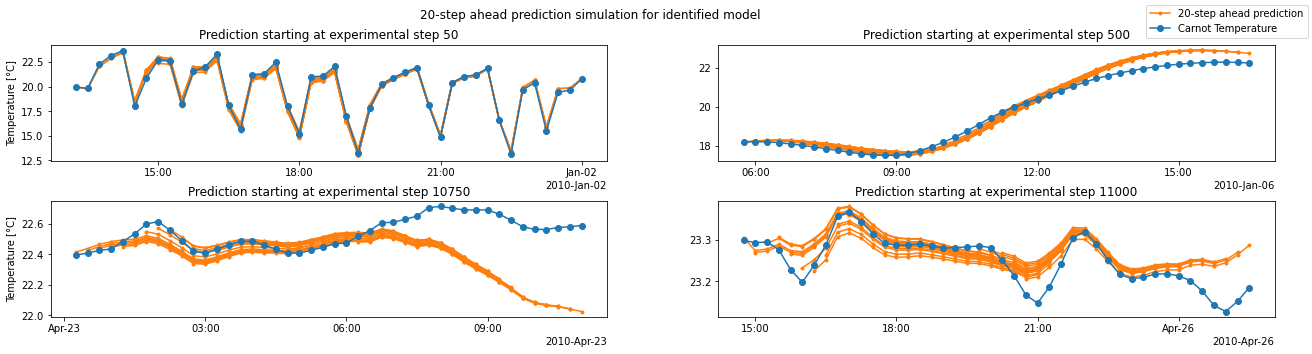

In [45]:
fig, ax = plt.subplots(2, 2, figsize=(20, 5))

iter_start_idx = iter([50, 500, 10750, 11000])

# x-axis handles
locators = []
formatters = []

for plt_idx in range(4):
    start_idx = next(iter_start_idx)
    # Subfigure
    plt.subplot(2, 2, plt_idx + 1)
    for idx in range(start_idx, start_idx + nb_predictions):
        df_iter = df_input.iloc[idx:(idx + N_pred)].copy()
        for idxx in range(N_pred - 1):
            idx_old = df_iter.index[idxx]
            idx_new = df_iter.index[idxx+1]
            mean, var = m.predict_f(df_iter.loc[idx_old, :].to_numpy().reshape(1, -1))
            df_iter.loc[idx_new, f'{y_name}_1'] = mean.numpy().flatten()
            for lag in range(2, dict_cols['y'][0] + 1):
                df_iter.loc[idx_new, f"{y_name}_{lag}"] = df_iter.loc[idx_old, f"{y_name}_{lag-1}"]

        mean_iter, _ = m.predict_f(df_iter.to_numpy())
        mean_iter = scaler_helper.inverse_scale_output(mean_iter) 
        l1 = plt.plot(df_iter.index, mean_iter, '.-', color = pallete[1], label = '20-step ahead prediction')
    l2 = plt.plot(df.iloc[3 + start_idx:2 + start_idx + nb_predictions + N_pred, 3], 'o-', color = pallete[0], label = 'Carnot Temperature')
    plt.title(f"Prediction starting at experimental step {start_idx}")
    
for ax_idx in range(2):
    for ax_idy in range(2):
        
        if ax_idx == 1:
            ax[ax_idx][ax_idy].set_xlabel("Experiment time [date]")
        
        ax[ax_idx][ax_idy].set_ylabel("Temperature [°C]")

        locators.append(mdates.AutoDateLocator(minticks=3, maxticks=6))
        formatters.append(mdates.ConciseDateFormatter(locators[-1]))
        ax[ax_idx][ax_idy].xaxis.set_major_locator(locators[-1])
        ax[ax_idx][ax_idy].xaxis.set_major_formatter(formatters[-1])

        
handles, labels = ax[0][0].get_legend_handles_labels()
idx = np.sort(np.unique(np.array(labels), return_index=True)[1])
fig.legend(np.array(handles)[idx], np.array(labels)[idx])
fig.suptitle("20-step ahead prediction simulation for identified model")

# Adjusting the sub-plots
plt.subplots_adjust(right=0.975)
fig.subplots_adjust(hspace=0.35)

#plt.savefig(f"prediction_{N_pred}_steps.png")
plt.savefig(f"../Thesis/Plots/{sim_id}_last_model_performance.pdf", bbox_inches='tight')

## Plot year-long evolution

In [24]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook

In [25]:
output_notebook()

Loading BokehJS ...

In [26]:
p = figure(plot_width = 1000, plot_height = 300)
#p.line(df.index, df['OutsideTemp'], line_color = pallete[0])
p.line(df.index, df['SimulatedTemp'], line_color = pallete[1])
p.line(df.index, df_tref, line_color = pallete[2])
p.line(df.index, df_rolling_temp, line_color = pallete[3])


show(p)

<ipython-input-27-82c377509efb>:13: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([l1, l2], labels=labels, loc = 'upper right')


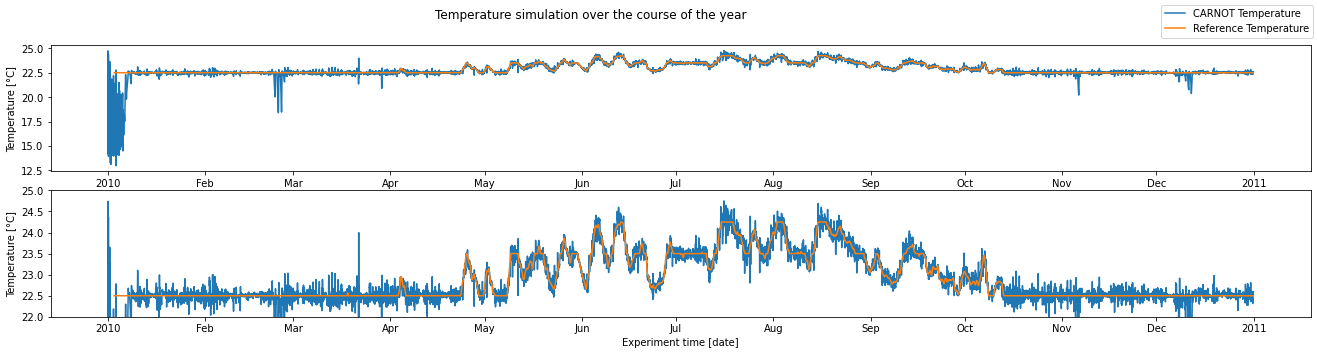

In [27]:
fig, ax = plt.subplots(2, 1, figsize=(20, 5))
#plt.plot(df.index, df['OutsideTemp'], color = 'blue')
l1 = ax[0].plot(df.index, df['SimulatedTemp'], color = pallete[0], label = 'CARNOT Temperature')
l2 = ax[0].plot(df.index, df_tref, color = pallete[1], label = 'Reference Temperature')

ax[1].plot(df.index, df['SimulatedTemp'], color = pallete[0], label = 'CARNOT Temperature')
ax[1].plot(df.index, df_tref, color = pallete[1], label = 'Reference Temperature')
ax[1].set_ylim([22,25])

labels = ['CARNOT Temperature', 'Reference Temperature']

fig.suptitle("Temperature simulation over the course of the year")
fig.legend([l1, l2], labels=labels, loc = 'upper right')

ax[0].set_ylabel("Temperature [°C]")
ax[1].set_ylabel("Temperature [°C]")

ax[1].set_xlabel("Experiment time [date]")

locator = mdates.AutoDateLocator(minticks=3, maxticks=14)
formatter = mdates.ConciseDateFormatter(locator)
for idx in range(2):
    ax[idx].xaxis.set_major_locator(locator)
    ax[idx].xaxis.set_major_formatter(formatter)



# Adjusting the sub-plots
plt.subplots_adjust(right=1)
fig.subplots_adjust(hspace=0.15)

plt.savefig(f"../Thesis/Plots/{sim_id}_fullyear.pdf", bbox_inches='tight')

In [28]:
cum_se = ((df['SimulatedTemp'][576:] - df_tref[576:])**2).sum()
print(cum_se)

1604.890433537764


In [29]:
p = figure(plot_width = 1000, plot_height = 300)
p.scatter(df.index, np.abs(df['SimulatedTemp'] - df_tref))
show(p)

In [30]:
pd.DataFrame(X_log[3], columns = data_to_gpr(df, dict_cols).drop(columns = df.columns).columns)

,SolRad_1,OutsideTemp_1,SimulatedHeat_1,SimulatedHeat_2,SimulatedTemp_1,SimulatedTemp_2,SimulatedTemp_3
0,-1.0,-0.989031,0.999999,0.999999,-0.217362,-0.470794,-0.158748
1,-1.0,-0.959781,0.999999,0.999999,-0.201597,-0.217362,-0.470794
2,-1.0,-0.945155,0.999999,0.999999,-0.185180,-0.201597,-0.217362
3,-1.0,-0.963437,0.999999,0.999999,-0.172228,-0.185180,-0.201597
4,-1.0,-0.981718,0.999999,0.999999,-0.162107,-0.172228,-0.185180
5,-1.0,-1.000000,0.999998,0.999999,-0.154548,-0.162107,-0.172228
6,-1.0,-1.018282,0.999999,0.999998,-0.149267,-0.154548,-0.162107
7,-1.0,-1.007313,0.999999,0.999999,-0.146012,-0.149267,-0.154548
8,-1.0,-0.996344,0.772654,0.999999,-0.142338,-0.146012,-0.149267


In [31]:
np_abserr = (df['SimulatedTemp'] - df_tref).abs()
abserr_mean = np_abserr.median()
abserr_std = np_abserr.std()

In [32]:
abserr_mean

0.054723545815473784

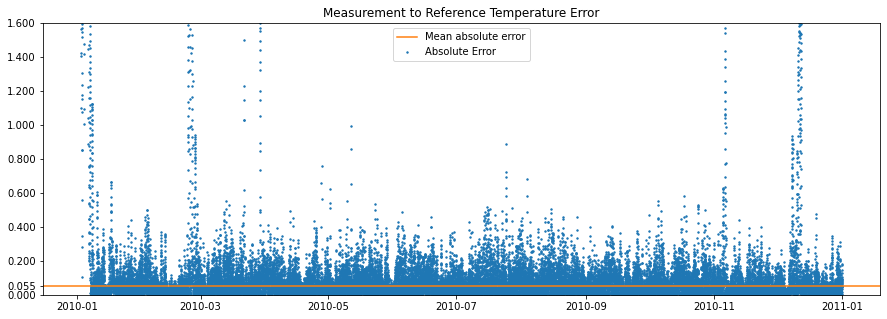

In [33]:
fig, ax = plt.subplots(figsize = (15, 5))

plt.scatter(df.index, np_abserr, s = 2, label = 'Absolute Error')

ax.set_ylim([0,1.5])
plt.yticks(list(plt.yticks()[0]) + [abserr_mean])
ax.axhline(y = abserr_mean, color = pallete[1], ls = '-', label = 'Mean absolute error')

plt.legend()

plt.title("Measurement to Reference Temperature Error")
plt.savefig(f"../Thesis/Plots/{sim_id}_abserr.pdf", bbox_inches='tight')

In [34]:
scaler_helper.inverse_scale_output(X_log[1][1,4])

array([16.07861433])

In [35]:
pd.DataFrame(X_log[3], columns = data_to_gpr(df, dict_cols).drop(columns = df.columns).columns)

,SolRad_1,OutsideTemp_1,SimulatedHeat_1,SimulatedHeat_2,SimulatedTemp_1,SimulatedTemp_2,SimulatedTemp_3
0,-1.0,-0.989031,0.999999,0.999999,-0.217362,-0.470794,-0.158748
1,-1.0,-0.959781,0.999999,0.999999,-0.201597,-0.217362,-0.470794
2,-1.0,-0.945155,0.999999,0.999999,-0.185180,-0.201597,-0.217362
3,-1.0,-0.963437,0.999999,0.999999,-0.172228,-0.185180,-0.201597
4,-1.0,-0.981718,0.999999,0.999999,-0.162107,-0.172228,-0.185180
5,-1.0,-1.000000,0.999998,0.999999,-0.154548,-0.162107,-0.172228
6,-1.0,-1.018282,0.999999,0.999998,-0.149267,-0.154548,-0.162107
7,-1.0,-1.007313,0.999999,0.999999,-0.146012,-0.149267,-0.154548
8,-1.0,-0.996344,0.772654,0.999999,-0.142338,-0.146012,-0.149267


In [36]:
pred_temp_log = []
last_temp_log = []
for idx in range(len(X_log)):
    pred_temp_log.append(
        scaler_helper.inverse_scale_output(X_log[idx][2,4])[0]
    )
    last_temp_log.append(
        scaler_helper.inverse_scale_output(X_log[idx][0,4])[0]
    )

In [37]:
df_test = df[nb_id_pts-1:].copy()

In [38]:
df_test.loc[:, 'MeasuredLastTemp'] = last_temp_log
df_test.loc[:, 'PredictedFirstStep'] = pred_temp_log
df_test

ValueError: Length of values (34554) does not match length of index (34938)

In [ ]:
(df_test['SimulatedTemp'] - df_test['PredictedFirstStep'].shift(1)).abs().plot(figsize = (15, 5))

In [ ]:
(df_test['SimulatedTemp'] - df_test['PredictedFirstStep'].shift(1)).abs().median()

In [ ]:
df_test['PredictedFirstStep'].plot(figsize = (15, 5))

In [ ]:
p = figure(plot_width = 1000, plot_height = 300)
p.line(df_test.index, df_test['PredictedFirstStep'], line_color = pallete[1])


show(p)

In [ ]:
df_test['PredictedFirstStep'].shift(-2)

In [ ]:
(df_test['SimulatedTemp'] - df_test['PredictedFirstStep'].shift(-2)).abs().plot(figsize = (15, 5))

In [ ]:
df_test['SimulatedTemp'] - df_test['PredictedFirstStep'].shift(-2)

In [ ]:
(df_test['SimulatedTemp'] - df_test['PredictedFirstStep'].shift(-3)).abs().mean()

In [ ]:
pd.DataFrame(X_log[0])

In [ ]:
np_params = np.empty((0, 8))
np_params

In [ ]:
for model in model_log:
    variance = gpflow.utilities.parameter_dict(model)['.kernel.variance'].numpy()
    lscales = gpflow.utilities.parameter_dict(model)['.kernel.lengthscales'].numpy()
    iter_params = np.hstack([variance, lscales])
    np_params = np.vstack([np_params, iter_params])

In [ ]:
np_params_idx = np.array([*range(np_params.shape[0])])

In [ ]:
p_list = []
for idx in range(1, np_params.shape[1]):
    p = figure(plot_width = 1000, plot_height = 150)
    p.line(np_params_idx, np_params[:, idx], line_color = pallete[idx])
    p_list.append(p)
show(column(p_list))